In [1]:
%set_env TF_FORCE_GPU_ALLOW_GROWTH=true
import pandas as pd
import numpy as np
import os
import re
from PIL import Image
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
%matplotlib inline

env: TF_FORCE_GPU_ALLOW_GROWTH=true


In [43]:
def preprocess_dataframe(df):
    
    '''
        Reads & preprocess dataframe w/ 3 labels: time, signal, label
    '''
    
    #df = df.iloc[:, 1:] # use system time - keep for DenoisedNormalizedData set
    df.columns = ['time','signal_val','label'] # set labels
    df = df.loc[df.time.notnull()].copy() # getting only not null values
    #df.time = (df.time * 1000).astype('int') #- keep for DenoisedNormalizedData set
    
    df = df.iloc[1:,:] # removes first row of labels
    
    df["label"] = df["label"].astype('str').astype('int')
    df["time"] = df["time"].astype('str').astype('int')
    df["signal_val"] = df["signal_val"].astype('str').astype('double')
    #df.label = df.label.astype('int') # labels as int - keep for DenoisedNormalizedData set
    
    return df

In [44]:
def import_train_test_data(data_dir, test_user=None):
    
    '''
        See here for more info:
        https://github.com/atabas/Heartbeat-Classification/blob/master/ImageConversion.ipynb
    '''
    
    train = pd.DataFrame([], columns=['time', 'signal_val', 'label'])    # train dataset
    test = pd.DataFrame([], columns=['time', 'signal_val', 'label'])     # test dataset
    #sumat = 0
    
    for filename in os.listdir(data_dir):
        if filename.endswith('.csv'):
            
            df = pd.read_csv(data_dir + '/' + filename, header=None)
            df = preprocess_dataframe(df)

            user_num = int(re.findall(r'\d+',filename.split('_')[0])[0]) #get user number
            
            # Check if ignore_user
            if (user_num != test_user):
                train = train.append(df)
            else:
                test = test.append(df)
 
    #print(sumat)
    return train, test

In [45]:
train_set, test_set = import_train_test_data('IRRlabeldata_3c',test_user=2)
#train_set, test_set = map_to_image(train, test)
train_set.shape

# removing first 2 rows since garbage data
test_set = test_set.iloc[2:,:]
train_set = train_set.iloc[2:,:]
test_set.head()

,time,signal_val,label
3,1642867,0.625378,0
4,1642871,0.386409,0
5,1642875,-0.033411,0
6,1642878,-0.313276,0
7,1642882,-0.128880,0


In [19]:
# droppping time column

train_set['signal_val'].max()


25.0

In [9]:
# Normalzing using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = train_set.append(test_set)

In [23]:
data.shape

(522777, 3)

In [31]:

scaler.fit(data.iloc[:,1:2])

MinMaxScaler()

In [32]:
train_set.iloc[:,1:2] = scaler.transform(train_set.iloc[:,1:2])
test_set.iloc[:,1:2] = scaler.transform(test_set.iloc[:,1:2])

In [5]:
train_set.min()

time         -66139.0
signal_val      -25.0
label             0.0
dtype: float64

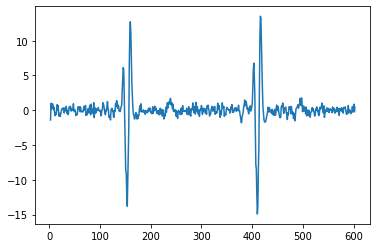

In [6]:
# Plotting
plt.plot(train_set['signal_val'].iloc[0:600])

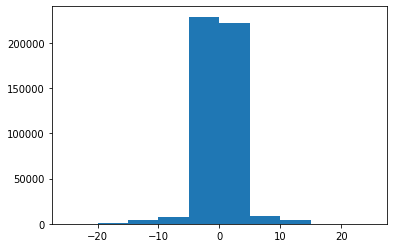

In [6]:
# distribution of signal vals
hist_train = plt.hist(train_set['signal_val'])

In [7]:
test_set.shape

(46389, 3)

In [8]:
train_set.value_counts()

time      signal_val  label
 1000      2.000000   2        10
-11206     25.000000  1         2
 0         25.000000  1         2
 5126890   2.791314   2         1
 1421386  -0.618326   0         1
                               ..
 3111945   11.808141  2         1
 3111949   0.799336   1         1
           11.971828  2         1
 3111953   1.487934   1         1
-66139    -6.392277   1         1
Length: 476377, dtype: int64

In [9]:
# Entries per label
test_set.groupby('label').size()

label
0     7678
1    10240
2    28471
dtype: int64

In [11]:
train_set.groupby('label').size()

label
0     84460
1    102400
2    289528
dtype: int64

In [13]:
train_set['signal_val'].max()

25.0

In [14]:
test_set['signal_val'].max()

10.243976366554334

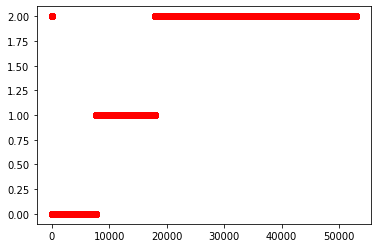

In [15]:
plt.plot(train_set['label'], 'ro')

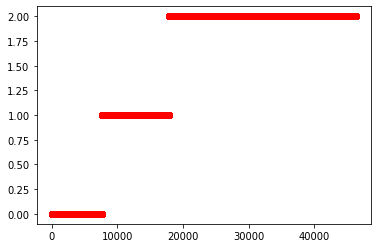

In [16]:
plt.plot(test_set['label'], 'ro')

In [46]:
from math import floor

def time_series_splicing(data, window_size=224):
    
    '''
       Create dataset from time-snippets of window_size length 
    '''
    
    # Dropping time column as not needed
    data = data.drop(columns=['time'])
    num_samples = floor(data.shape[0] / window_size)
    
    print('Total # of samples of window_size = {}: {}'. format(window_size, num_samples))
    
    result = np.empty(shape=(num_samples, 224, 2))
    
    start = 0;
    
    for i in range(num_samples):
        
        # splice original dataframe into window_size chunks
        result[i,:,:] = data.iloc[start : start + window_size, :]
        start = start + window_size
    
    print('Splicing done; {} original entries discarded'.format(data.shape[0] - start))
    
    return result

In [47]:
ts_window_size = 224 #224 samples per 1 sample

train_set = time_series_splicing(train_set, ts_window_size)
test_set = time_series_splicing(test_set, ts_window_size)

Total # of samples of window_size = 224: 2126
Splicing done; 164 original entries discarded
Total # of samples of window_size = 224: 207
Splicing done; 21 original entries discarded


In [48]:
from sklearn.model_selection import train_test_split

# Splitting into training and validation sets
val_size = 0.2 # 20%
train_set, val_set = train_test_split(train_set, test_size = 0.2)

In [49]:
def preprocess_categorical(data):
    '''
        Process sample labeling to categorical major label (per sample)
    '''
    samples = data[:,:,0]
    labels = np.empty(shape=(data.shape[0],), dtype='int')
    
    for i in range(data.shape[0]):
        label0 = np.count_nonzero(data[i,:,1] == 0)
        label1 = np.count_nonzero(data[i,:,1] == 1)
        label2 = np.count_nonzero(data[i,:,1] == 2)
    
        occurence = [label0, label1, label2]

        major_label = occurence.index(max(occurence))

        labels[i] = major_label

    # to categorical using one-hot
    labels = keras.utils.to_categorical(labels, num_classes=3)
    
    return samples, labels

In [50]:
x_train, y_train = preprocess_categorical(train_set)

In [51]:
x_test, y_test = preprocess_categorical(test_set)

In [52]:
x_val, y_val = preprocess_categorical(val_set)

In [9]:
train.shape

(1700, 224, 2)

In [23]:
val.shape

(426, 224, 2)

## InceptionTime Model

In [25]:
train_set.shape[1:]

(224, 2)

In [41]:
# Split samples and labels
x_train = train[:,:,0]
y_train = train[:,:,1]

x_test = test[:,:,0]
y_test = test[:,:,1]

x_val = val[:,:,0]
y_val = val[:,:,1]


In [10]:
# Transform to tf.data.Dataset for easy pipeline
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# Create batches
BATCH_SIZE = 12

train_batch = train_data.batch(BATCH_SIZE)
test_batch = test_data.batch(BATCH_SIZE)
val_batch = val_data.batch(BATCH_SIZE)

In [53]:
# Load model
from inceptionTime import inceptionTime
import os
model = inceptionTime(os.getcwd(), input_shape=(224,1), nb_classes=3, verbose=True, build=True)
'''
model = inception_time(input_shape=(224,1),
                       num_classes=224, 
                       loss=tf.keras.losses.MeanSquaredError(), 
                       batch_size=BATCH_SIZE, 
                       num_modules=6)
'''

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 1)]     0                                            
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 224, 1)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 224, 32)      1280        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 224, 32)      640         input_1[0][0]                    
______________________________________________________________________________________________

'\nmodel = inception_time(input_shape=(224,1),\n                       num_classes=224, \n                       loss=tf.keras.losses.MeanSquaredError(), \n                       batch_size=BATCH_SIZE, \n                       num_modules=6)\n'

In [54]:
model.fit(x_train, y_train, x_val, y_val, y_test)

Epoch 1/1500
27/27 [==============================] - 18s 653ms/step - loss: 0.9959 - accuracy: 0.5747 - lr: 0.0010
Epoch 2/1500
27/27 [==============================] - 1s 26ms/step - loss: 0.9455 - accuracy: 0.6006 - lr: 0.0010
Epoch 3/1500
27/27 [==============================] - 1s 26ms/step - loss: 0.9352 - accuracy: 0.6035 - lr: 0.0010
Epoch 4/1500
27/27 [==============================] - 1s 26ms/step - loss: 0.9261 - accuracy: 0.6006 - lr: 0.0010
Epoch 5/1500
27/27 [==============================] - 1s 26ms/step - loss: 0.9173 - accuracy: 0.6100 - lr: 0.0010
Epoch 6/1500
27/27 [==============================] - 1s 25ms/step - loss: 0.8945 - accuracy: 0.6218 - lr: 0.0010
Epoch 7/1500
27/27 [==============================] - 1s 26ms/step - loss: 0.8894 - accuracy: 0.6206 - lr: 0.0010
Epoch 8/1500
27/27 [==============================] - 1s 26ms/step - loss: 0.8882 - accuracy: 0.6176 - lr: 0.0010
Epoch 9/1500
27/27 [==============================] - 1s 26ms/step - loss: 0.8705 - ac

KeyboardInterrupt: 

### Benchmarks

##### InceptionTime Regression

Using MSE and RELU output activation, at epoch 16, accuracy ~0.15, loss ~0.3495
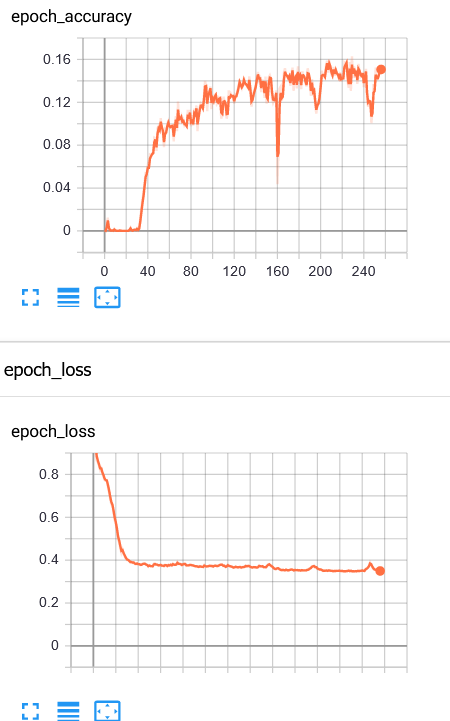